In [5]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from power.ml_ops.data import get_pv_data, clean_pv_data, get_data_with_cache
from power.ml_ops.model import model_yesterday
from power.ml_ops.registry import load_model


from pathlib import Path
from power.params import *

# API requests

In [6]:
input_prediction_date = "2019-12-10 00:00:00"
# make api call
base_url = "http://127.0.0.1:8000"

# model
params_model ={
    'input_date':input_prediction_date,
    'n_days': 2,
    'power_source': 'pv'
    }

endpoint_model = "/baseline_yesterday"
url_model= f"{base_url}{endpoint_model}"
response_model = requests.get(url_model, params_model).json()

# baseline
params_baseline ={
    'input_date':input_prediction_date,
    'n_days': 2,
    'power_source': 'pv'
    }

endpoint_baseline = "/baseline_yesterday"
url_baseline= f"{base_url}{endpoint_baseline}"
response_baseline = requests.get(url_baseline, params_baseline).json()

# data
params_data ={
    'input_date':input_prediction_date,
    'n_days': 10,
    'power_source': 'pv'
    }

endpoint_data = "/extract_data"
url_data = f"{base_url}{endpoint_data}"
response_data = requests.get(url_data, params_data).json()


# Make plots

In [7]:
# set-up 4 DatFrames according to input date and type of model
X = pd.DataFrame(response_data.get(input_prediction_date)['days_before'])
y = pd.DataFrame(response_data.get(input_prediction_date)['day_after'])
y_baseline = pd.DataFrame(response_baseline.get(input_prediction_date))
y_predicted = pd.DataFrame(response_model.get('dataframe to predict'))

In [8]:
# convert date columns to datetime object
X.date = pd.to_datetime(X.date,utc=True)
y.date = pd.to_datetime(y.date, utc=True)
y_baseline.date = pd.to_datetime(y_baseline.date, utc=True) + datetime.timedelta(days=1)

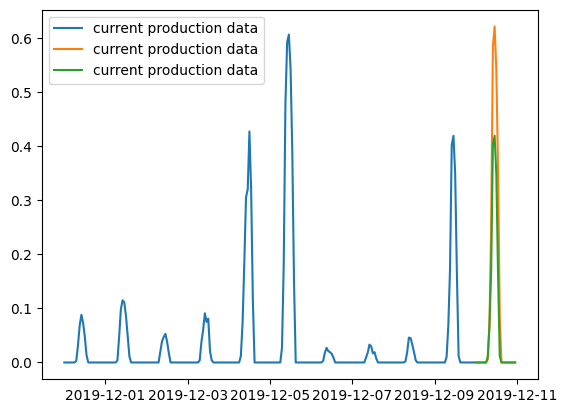

In [18]:
fig, ax = plt.subplots()
ax.plot(X.date, X.power_source, label='current production data')
ax.plot(y.date, y.power_source, label='current production data')
ax.plot(y_baseline.date, y_baseline.power_source, label='current production data')
plt.legend()


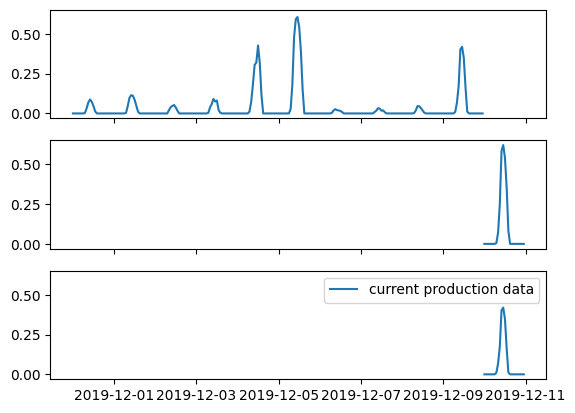

In [10]:
fig, ax = plt.subplots(nrows = 3, sharex=True, sharey=True)
ax[0].plot(X.date, X.power_source, label='current production data')
ax[1].plot(y.date, y.power_source, label='current production data')
ax[2].plot(y_baseline.date, y_baseline.power_source, label='current production data')
plt.legend()


In [12]:
# Metrics
mean_training = X.power_source.mean()
mean_predicted = y_baseline.power_source.mean()
mean_diff = mean_predicted - mean_training
mean_training, mean_predicted,mean_diff

(0.03402083333333334, 0.06658333333333333, 0.03256249999999999)

# Tests API endpoints

In [13]:
def predict_baseline_yesterday(input_date: str):
    data = data_pv_clean[data_pv_clean['utc_time'] < input_date][-24:]
    values = data.electricity.to_list()
    return {input_date: values}

predict_baseline_yesterday(input_prediction_date)

In [14]:
def extract_pv_data(input_date: str, n_days=10):
    """
    Returns the power data for the n_days before the input date
    Also returns the power data for the following day
    """
    n_rows = 24 * n_days
    days_before = data_pv_clean[data_pv_clean['utc_time'] < input_date] \
                                        ['electricity'][-n_rows:].to_list()
    day_after = data_pv_clean[data_pv_clean['utc_time'] >= input_date] \
                                        ['electricity'][:24].to_list()


    extracted_data = {
        'days_before':days_before,
        'day_after':day_after
        }

    return {input_date: extracted_data}

# extract_pv_data(input_prediction_date)

In [15]:
def predict(input_date: str, n_days=2):
    pv_data_clean = data_pv_clean
    X_pred = pv_data_clean[pv_data_clean['utc_time'] < input_date][-48:]

    return {'dataframe to predict': X_pred.electricity.to_list()}

# predict(input_prediction_date)